In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from statsmodels.stats.weightstats import ztest as ztest


%matplotlib inline  

In [8]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [9]:
market_ticker = '^GSPC'
stock_ticker = 'acn'

stime='2022-01-01'
ftime=None

In [10]:
def get_data_from_ticker(tick, stime, ftime, interval='1d'):
    ticker = yf.Ticker(tick)
    # df = ticker.history(start='2021-01-01', end='2022-06-30')
    # df = ticker.history(start='2021-01-01', end='2022-07-26')
    # df = ticker.history(start='2020-01-01', end='2021-01-01')
    # df = ticker.history(start='2022-05-28')
    df = ticker.history(start=stime, end=ftime, interval=interval)
    x = pd.DataFrame(df)
    x.rename(columns={"Close": tick}, inplace=True)
    z = x.drop(columns=["Open", "High", "Low", "Volume", "Dividends", "Stock Splits"])
    return z

gf = pd.DataFrame(get_data_from_ticker(market_ticker, stime, ftime))
sf = pd.DataFrame(get_data_from_ticker(stock_ticker, stime, ftime))
gf[stock_ticker] = sf[stock_ticker]


gf.head(3)

,^GSPC,acn
Date,,
2022-01-03 00:00:00-05:00,4796.560059,401.729431
2022-01-04 00:00:00-05:00,4793.540039,398.858582
2022-01-05 00:00:00-05:00,4700.580078,391.834412


In [11]:
def add_percent_update(tick):
    """ date stock's or market's update"""
    gf_copy = gf.copy(deep=True)
    gf_copy = pd.DataFrame(gf_copy.drop(gf.index[0]))
    gf_copy_v = gf_copy[tick].values
    gf_v = gf.copy(deep=True)
    gf_vv = gf_v[tick].values

    for i in range(len(gf_copy)):
        gf_vv[i] = (gf_copy_v[i] - gf_vv[i]) / (gf_vv[i] / 100)

    gf_vv = np.insert(gf_vv, 0, 0)
    gf_vv = np.delete(gf_vv, -1)
    return gf_vv

gf[f"% update {market_ticker}"] = add_percent_update(market_ticker)
gf[f"% update {stock_ticker}"] = add_percent_update(stock_ticker)

gf.head(3)

,^GSPC,acn,% update ^GSPC,% update acn
Date,,,,
2022-01-03 00:00:00-05:00,4796.560059,401.729431,0.000000,0.000000
2022-01-04 00:00:00-05:00,4793.540039,398.858582,-0.062962,-0.714623
2022-01-05 00:00:00-05:00,4700.580078,391.834412,-1.939276,-1.761068


ztest

In [18]:
ztest(gf['% update ^GSPC'].values, value= gf['% update ^GSPC'].mean()) 

(0.0, 1.0)

корреляция

In [19]:
np.corrcoef(gf['% update ^GSPC'].values, gf['% update acn'].values)

array([[1.        , 0.88236833],
       [0.88236833, 1.        ]])

(array([ 1.,  1.,  1.,  0.,  2.,  1.,  2.,  0.,  2.,  3.,  0.,  5.,  0.,
         4.,  4.,  6.,  6.,  4.,  6., 10., 10., 17., 10., 12., 10., 19.,
         8.,  8.,  9.,  9.,  6.,  5.,  8.,  8.,  5.,  8.,  3.,  6.,  3.,
         4.,  2.,  6.,  4.,  1.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-4.32366134, -4.15920951, -3.99475768, -3.83030585, -3.66585402,
        -3.50140219, -3.33695036, -3.17249853, -3.0080467 , -2.84359487,
        -2.67914304, -2.51469121, -2.35023938, -2.18578756, -2.02133573,
        -1.8568839 , -1.69243207, -1.52798024, -1.36352841, -1.19907658,
        -1.03462475, -0.87017292, -0.70572109, -0.54126926, -0.37681743,
        -0.2123656 , -0.04791377,  0.11653806,  0.28098989,  0.44544172,
         0.60989355,  0.77434538,  0.93879721,  1.10324904,  1.26770087,
         1.4321527 ,  1.59660453,  1.76105636,  1.92550818,  2.08996001,
         2.25441184,  2.41886367,  2.5833155 ,  2.74776733,  2.91221916,
 

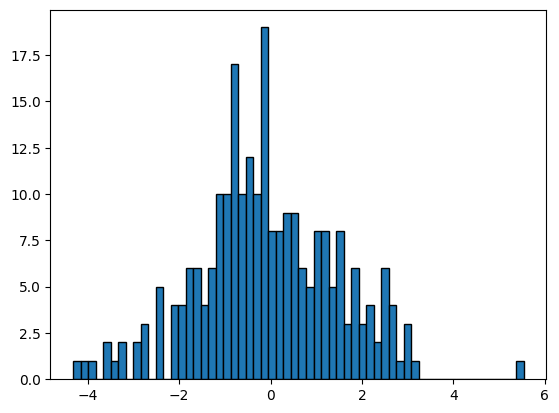

In [12]:
plt.hist(list(gf['% update ^GSPC'].values), bins=60, edgecolor='black')

(array([ 3.,  0.,  0.,  1.,  1.,  1.,  1.,  2.,  0.,  5.,  5.,  3.,  2.,
         2.,  0.,  5.,  4.,  9.,  8., 11., 10., 10., 14.,  8., 11., 16.,
        16.,  7., 10.,  7., 14.,  6.,  4.,  5.,  7.,  9.,  1.,  4.,  3.,
         7.,  2.,  2.,  1.,  0.,  2.,  3.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([-5.91917488e+00, -5.69178763e+00, -5.46440037e+00, -5.23701312e+00,
        -5.00962586e+00, -4.78223861e+00, -4.55485136e+00, -4.32746410e+00,
        -4.10007685e+00, -3.87268960e+00, -3.64530234e+00, -3.41791509e+00,
        -3.19052783e+00, -2.96314058e+00, -2.73575333e+00, -2.50836607e+00,
        -2.28097882e+00, -2.05359157e+00, -1.82620431e+00, -1.59881706e+00,
        -1.37142980e+00, -1.14404255e+00, -9.16655297e-01, -6.89268043e-01,
        -4.61880789e-01, -2.34493536e-01, -7.10628186e-03,  2.20280972e-01,
         4.47668226e-01,  6.75055479e-01,  9.02442733e-01,  1.12982999e+00,
         1.35721724e+00,  1.58460449e+00,  1.81199

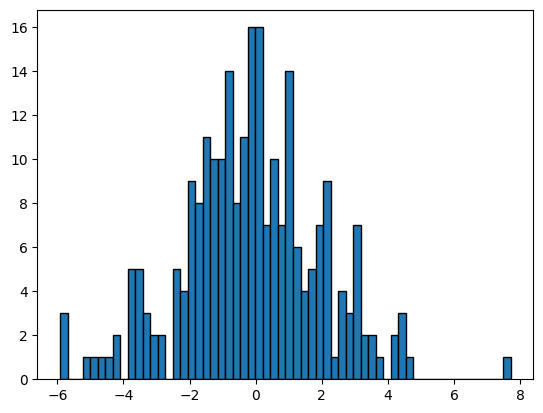

In [13]:
plt.hist(list(gf['% update acn'].values), bins=60, edgecolor='black')

математическое ожидание

In [14]:
# %time snp_mat_expectation = gf['% update ^GSPC'].sum() / gf['% update ^GSPC'].value_counts().sum()
# %time snp_mat_expectation = np.average(gf['% update ^GSPC'])
snp_mat_expectation = gf['% update ^GSPC'].mean()
snp_mat_expectation

-0.08139944615926793

стандартное отклонение

In [15]:
snp_standart_deviation = gf['% update ^GSPC'].std()
snp_standart_deviation

1.5311950210957277

In [16]:
snp_standart_deviation = gf['% update acn'].std()
snp_standart_deviation

2.09860266456109

In [17]:
mu_z = gf['% update ^GSPC'].mean()
# se_z = gf['% update ^GSPC'].std() / sqrt(gf['% update ^GSPC'].value_counts().sum())
se_z = gf['% update ^GSPC'].std() 
z_values_snp = [(x - mu_z) / se_z for x in gf['% update ^GSPC']]

z_values_snp[:5]

[0.05316073069583145,
 0.012041085687455195,
 -1.213350557775419,
 -0.009781546605855073,
 -0.21135271692453914]